In [5]:
import torch
import torch.nn               as nn
import torch.nn.parallel
import torch.optim            as optim
import torch.utils.data
import torchvision.datasets   as dset
import torchvision.transforms as transforms
import torchvision.utils      as vutils

import numpy                  as np
import matplotlib.pyplot      as plt
import matplotlib.animation   as animation

import model                  as m
from IPython.display          import HTML

In [6]:
# Hyperparameters
data_dir       = "data/celeba"
workers        = 2
batch_size     = 128
img_size       = 64
img_channels   = 3
z_dim          = 100
g_hidden_dim   = 64
d_hidden_dim   = 64
epochs         = 20
lr             = 2e-4
betas          = (0.5, 0.999)
device         = "cuda"

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

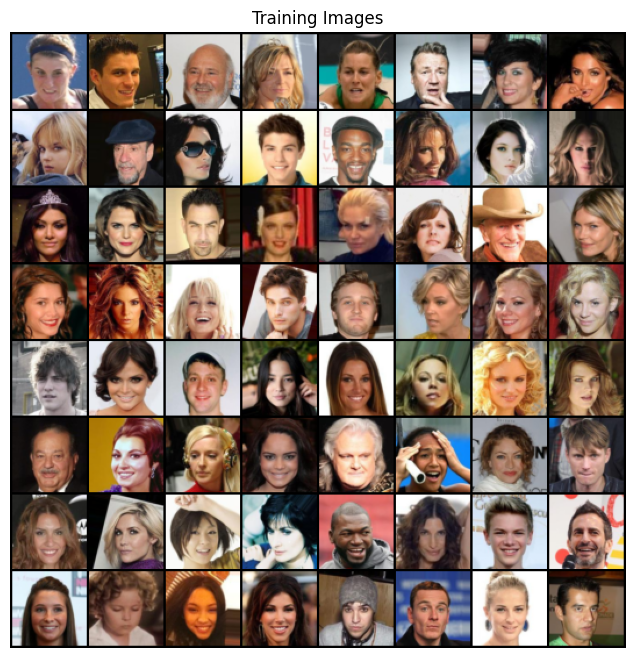

In [7]:
dataset = dset.ImageFolder(root=data_dir,
                           transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [8]:
gen = m.Generator(z_dim, g_hidden_dim, img_channels).to(device)
dis = m.Discriminator(img_channels, d_hidden_dim).to(device)

gen.apply(m.weights_init)
dis.apply(m.weights_init)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_

In [9]:
criterion = nn.BCELoss()

# Used to track the generator's progress
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

gen_optim = optim.Adam(gen.parameters(), lr=lr, betas=betas)
dis_optim = optim.Adam(dis.parameters(), lr=lr, betas=betas)

In [ ]:
img_list = []
gen_losses = []
dis_losses = []
iters = 0

print("Training...")
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # Train discriminator with real images
        dis.zero_grad()
        real = data[0].to(device)
        cur_batch_size = real.size(0)
        real_pred = dis(real).view(-1)
        real_loss = criterion(real_pred, torch.ones_like(real_pred, dtype=torch.float))
        real_loss.backward()
        d_x = real_pred.mean().item()

        # Train discriminator with fake images
        noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake = gen(noise)
        fake_pred = dis(fake.detach()).view(-1)
        fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred, dtype=torch.float))
        fake_loss.backward()
        d_g_z1 = fake_pred.mean().item()

        dis_optim.step()

        # Train generator
        gen.zero_grad()
        fake_pred = dis(fake).view(-1)
        gen_loss = criterion(fake_pred, torch.ones_like(fake_pred, dtype=torch.float))
        gen_loss.backward()
        d_g_z2 = fake_pred.mean().item()

        gen_optim.step()

        if i % 100 == 0:
            print("[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f" 
                  % (epoch, epochs, i, len(dataloader), fake_loss.item(), gen_loss.item(), d_x, d_g_z1, d_g_z2))
            
        gen_losses.append(gen_loss)
        dis_losses.append(fake_loss)

        if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


In [15]:
# plt.figure(figsize=(10, 5))
# plt.title("Generator and Discriminator Loss During Training")
# plt.plot(gen_losses, label="Generator")
# plt.plot(dis_losses, label="Discriminator")
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [18]:
# f = plt.figure(figsize=(8, 8))
# plt.axis("off")

# ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(f, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

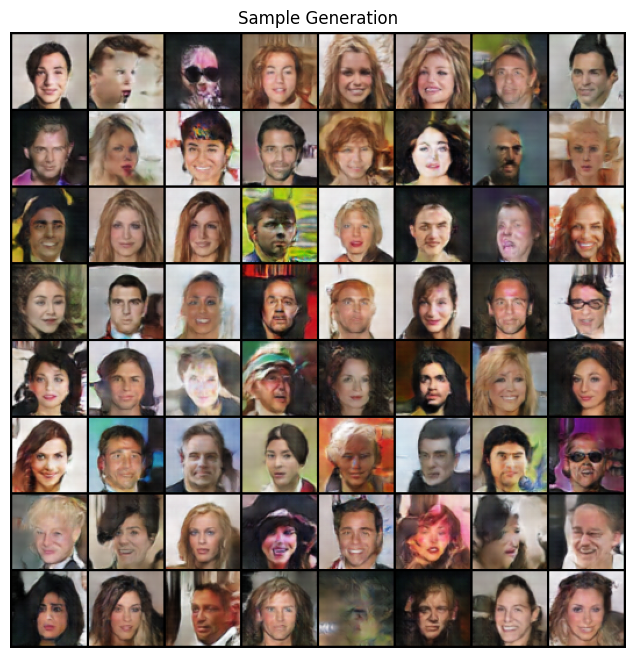

In [17]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Generation")
plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()